In [1]:
######################################################
### Attaching and downloading necessary packagaes ####
######################################################
# if (!requireNamespace("BiocManager", quietly = FALSE))
#     install.packages("BiocManager")
# BiocManager::version()
# library("devtools")
# devtools::install_github("broadinstitute/infercnv", force=TRUE)
# detach("package:infercnv", unload=T)  ### package infercnv_1.15.3  seems to work fine
library(infercnv)
#### loading packages and others 
library("Seurat")
library("tidyverse")
#remotes::install_github("mojaveazure/seurat-disk")
library("SeuratDisk")
#install.packages("ggplot2")
library(ggplot2)
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
library(DoubletFinder)
library(dplyr)
library(tidyverse)

Attaching SeuratObject

-- Attaching core tidyverse packages -------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.1     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [2]:
## Step 1 . Read a scRNA file 
dat <- Read10X_h5("/data/kumarr9/scRNA/SCAF3163_83-48-12-1_filtered_feature_bc_matrix.h5")

## step 2 . creating seurat object with with desired cell and gene parameters and also name the project
dat_seurat_obj <- CreateSeuratObject(counts = dat, min.cells = 3, min.features = 200, project = 'SCLC')

## step 3 . Identifying mitochindrial contamination-- and adding it to seurat object -- use MT when human and mt when mouse
dat_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(dat_seurat_obj, pattern = "^MT-")
#View(dat_seurat_obj@meta.data) ## to visualize the data to see mitochondrial cells contamination

## step 4. plotting the mitochondrial contamination or data distribution
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/data_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

## step 5. viewing data distribution before mitochondrial contamination removal
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/data_distribution.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features <- plot1 + plot2
SCAF3163_features
dev.off()

## step 6. Removing low quality cells and mitochondrial contamination
dat_seurat_obj_filtered <- subset(dat_seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### just to see what number of cells left after feature selection 
#dat_seurat_obj
#dat_seurat_obj_filtered

## step 7. plots the results after filtering or filtered features
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/data_filtered_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/data_distribution_filtered_features.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features_filtered <- plot1 + plot2
SCAF3163_features_filtered
dev.off()

png 
  2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

png 
  2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

In [3]:
#### Before any kind of scRNA, need to do the Normalization ###
### After removing unwanted cells from the dataset, the next step is to normalize the data. I employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result

## step 8. Normalization of the data 
dat_seurat_obj_filtered <- NormalizeData(dat_seurat_obj_filtered)

## step 9. Identifying highly variable features from the normalized data 
## We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). 
## focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
# Identify the 10 most highly variable genes  (change to to your desired number of genes)
top10 <- head(VariableFeatures(dat_seurat_obj_filtered), 10)

# plot variable features with and without labels
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/most_variable.jpg", width = 3000, height = 2000, res=300)
plot1 <- VariableFeaturePlot(dat_seurat_obj_filtered)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
SCAF3163_filterd_variable <- plot1 + plot2
SCAF3163_filterd_variable
dev.off()

## step 10. scale the data, Regression should be done during scaling of the data 
#(Note - here, we can also, remove unwanted source of vaiation like mitochondrial cell or cell cycle etc., see vignettes for more details)
# Shifts the expression of each gene, so that the mean expression across cells is 0
#Scales the expression of each gene, so that the variance across cells is 1
#This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
#The results of this are stored in pbmc[["RNA"]]@scale.data
#############################################
### Parth ask to assign cell cycle score ####
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/difference_regressed_cell_cyle_SCAF2221.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))
DimPlot(dat_seurat_obj_filtered)
dev.off()


## step 11. Run PCA to educe the dimensionality
# By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset, like this pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
dat_seurat_obj_filtered <- RunPCA(object = dat_seurat_obj_filtered)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/elbow.jpg", width = 3000, height = 2000, res=300)
ElbowPlot(dat_seurat_obj_filtered)
dev.off()
# Examine and visualize PCA results a few different ways
#print(dat_seurat_obj_filtered[["pca"]], dims = 1:5, nfeatures = 5)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/PCA_plots_heterogeneity.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "pca")
dev.off()

## step 12. clusters the cells 
# Now using the elbow method we determine the neighbours, make the clusters of neighbour and then ran the UMAP to plot the same
dat_seurat_obj_filtered <- FindNeighbors(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
View(dat_seurat_obj_filtered@meta.data)
# optional step (to set the granularity of the data, i mean the number of clusters to be shown in UMAP)
## seeing or setting identity of clusters  
## Idents function store the identity of cluster
#head(Idents(dat_seurat_obj_filtered), 5) 
#Idents(dat_seurat_obj_filtered)
# when want to set the identity 
#Idents(dat_seurat_obj_filtered) <- SCLC_snn_res_0.3 ## this will set the resolution at 0.3 and make the only number of clusters which are in 0.3 resolution

dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/UMAP.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)
dev.off()

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


png 
  2

Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"
Regressing out CC.Difference

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1"
Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
PC_ 1 
Positive:  TYMS, NUSAP1, HMGB2, RRM2, TOP2A, RRM1, SMC4, TMPO, UBE2C, CDK1 
	   PCNA, MKI67, CENPF, FEN1, NDC80, CLSPN, CKAP2, RAD51AP1, CCNE2, TPX2 
	   CKS2, ECT2, CDC6, MCM2, CCNB2, CKS1B, DTL, USP1, UHRF1, NASP 
Negative:  RANGAP1, TIPIN, G2E3, CDCA7, CTCF, CENPE, LBR, MCM6, GAS2L3, MCM5 
	   KIF20B, CASP8AP2, TACC3, AURKA, PSRC1, NCA

png 
  2

PC_ 1 
Positive:  TUBA1B, GRP, SEC11C, COL1A2, HSP90AA1, NUSAP1, UBE2C, TOP2A, IGFBP2, CLDN4 
	   HMGB2, UCHL1, CENPF, TFF3, CCNB2, CCNB1, PRC1, RRM2, CRABP1, MKI67 
	   ECT2, CDK1, TPX2, CDC20, RASD1, NDC80, BIRC5, CRYBG3, KRT19, YBX1 
Negative:  HLA-B, SRGN, PTPRC, IL32, CD3E, ARHGDIB, CD52, TNFAIP3, HLA-C, HLA-E 
	   SLC2A3, RAC2, IL2RG, DUSP2, S100A4, RGCC, VIM, CD3D, CD2, ITGB2 
	   TSC22D3, HCST, FYB1, FXYD5, CD37, LCP1, CORO1A, LAPTM5, TGFB1, CST7 
PC_ 2 
Positive:  IGFBP7, IFITM3, COL6A2, IGFBP4, SPARCL1, SOD3, DCN, C1S, SPARC, MMP2 
	   COL6A1, CALD1, CTSK, COL15A1, APOD, CFH, NNMT, PLPP3, TIMP1, CCN1 
	   SERPINF1, COL1A1, PLAC9, COL4A2, PDGFRB, GSN, COL18A1, CFD, CAVIN1, COL3A1 
Negative:  PTPRC, CD3E, CXCR4, CORO1A, DUSP2, CD52, CD2, IL2RG, CD3D, RAC2 
	   HCST, LAT, CST7, FYB1, LCK, CYTIP, ICOS, EZR, CD48, LCP1 
	   ITGB2, TBC1D10C, STK17B, CD3G, CD37, RHOH, SPOCK2, RGS1, SAMSN1, TRBC2 
PC_ 3 
Positive:  PLVAP, PECAM1, ADGRL4, RAMP3, VWF, ESAM, CD34, FLT1, GNG11, AQP1 
	  

png 
  2

png 
  2

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4165
Number of edges: 152008

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8389
Number of communities: 17
Elapsed time: 0 seconds


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.8,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>
AAACCTGAGCGTAGTG-1,SCLC,5191,2420,3.37121942,0.0007310139,0.121513035,G2M,SCLC,-0.120782021,1,1
AAACCTGAGCGTGAAC-1,SCLC,1234,724,3.48460292,-0.1001472633,0.041424437,G2M,SCLC,-0.141571700,15,15
AAACCTGCAAGCCATT-1,SCLC,3399,1720,3.58929097,-0.2308804108,-0.174718388,G1,SCLC,-0.056162023,0,0
AAACCTGGTCGGCACT-1,SCLC,7160,2427,0.83798883,-0.2501822531,-0.388665370,G1,SCLC,0.138483117,0,0
AAACCTGTCAACCATG-1,SCLC,2710,1579,4.39114391,-0.1353276477,-0.162536215,G1,SCLC,0.027208567,2,2
AAACCTGTCGGGAGTA-1,SCLC,567,217,4.05643739,-0.0497389961,-0.126676835,G1,SCLC,0.076937838,9,9
AAACCTGTCTGTCTAT-1,SCLC,2170,1180,1.05990783,0.0840903970,-0.112130007,S,SCLC,0.196220404,3,3
AAACGGGAGAATGTGT-1,SCLC,1238,824,0.08077544,-0.0988309998,-0.233477061,G1,SCLC,0.134646061,3,3
AAACGGGAGATACACA-1,SCLC,4119,1877,3.20466133,0.0067383124,-0.324331790,S,SCLC,0.331070103,2,2


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
10:25:09 UMAP embedding parameters a = 0.9922 b = 1.112

10:25:09 Read 4165 rows and found 20 numeric columns

10:25:09 Using Annoy for neighbor search, n_neighbors = 30

10:25:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:25:10 Writing NN index file to temp file /lscratch/3295122/RtmpFylVMW/file5c5f31e5e880

10:25:10 Searching Annoy index using 1 thread, search_k = 3000

10:25:12 Annoy recall = 100%

10:25:13 Commencing smooth kNN distance calibration using 1 thread
 with target 

png 
  2

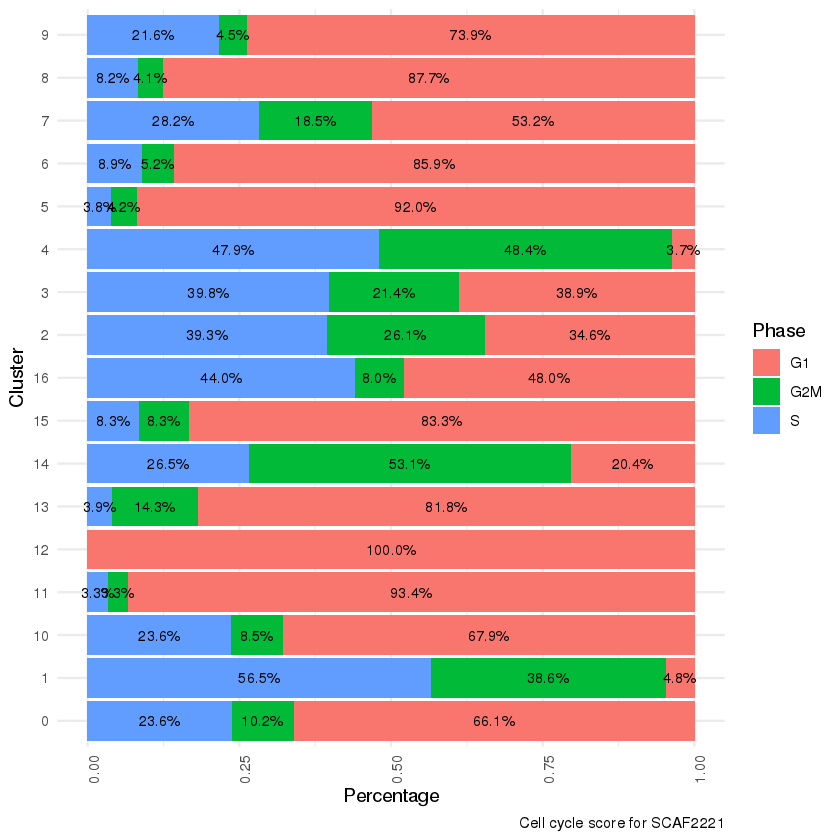

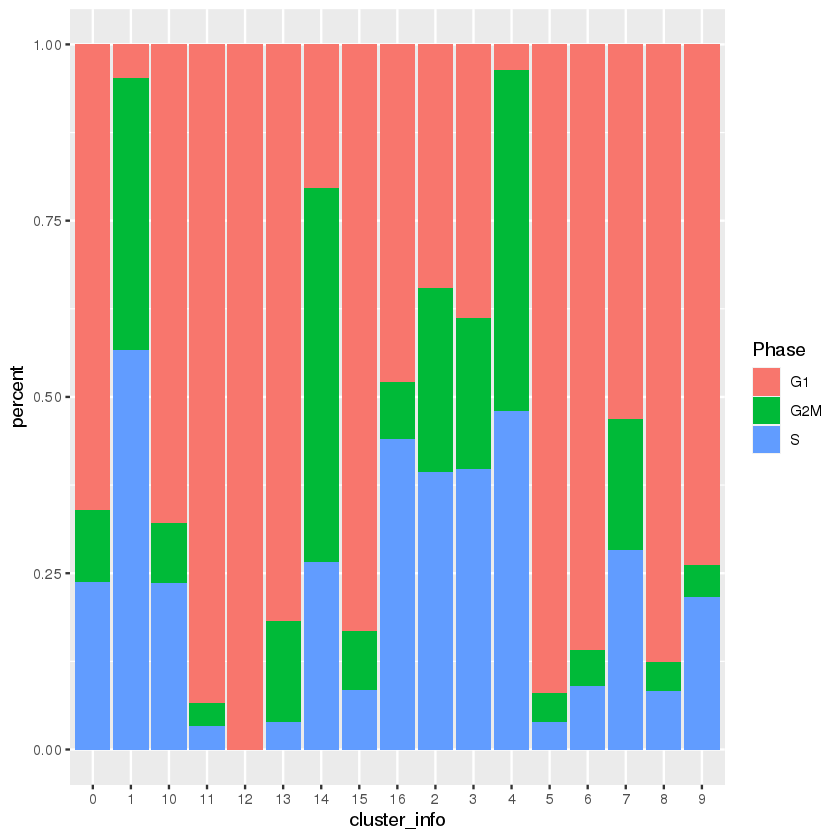

In [5]:
# Plotting for cell cycle scores
##### seeing the object formed for cell cycle scores ####
#head(dat_seurat_obj_filtered[[]])
#str(dat_seurat_obj_filtered)
#Getting Cell cycle scores from the seurat object 
S_score <- dat_seurat_obj_filtered@meta.data$S.Score
g2m_score <- dat_seurat_obj_filtered@meta.data$G2M.Score
cluster_info <- as.numeric(as.character(dat_seurat_obj_filtered@meta.data$seurat_clusters))
Phase <- dat_seurat_obj_filtered@meta.data$Phase
# View(S_score)
# View(g2m_score)
# View(cluster_info)
# View(Phase)
# making dataframe by combining relative stuff what we want to show in plot
cell_df <- cbind(cluster_info, Phase, g2m_score, S_score)

## converting to dataframe and calculating the percentage for stacked bar plot 
# link - https://rpubs.com/techanswers88/stackedbarcharts
cell_df <- data.frame(cell_df)
dt <- cell_df%>%
  dplyr::group_by(cluster_info, Phase)%>%
  dplyr::tally()%>%
  dplyr::mutate(percent=n/sum(n))

## plotting the result 
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_stack(vjust=0.5), colour="white", size = 2)


# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 ))
# pl
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/cell_cycle.jpg", width = 2000, height = 1200, res=300)
pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
pl <- pl + geom_bar(stat="identity", position ="fill")
pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
                     position=position_fill(vjust=0.5), colour="black", size =3)

pl <- pl + theme_minimal()
#pl <- pl + labs(title ="Cell cycle score for SCAF2229")
#pl <- pl + labs(subtitle ="plot")
pl <- pl + labs(caption ="Cell cycle score for SCAF2221")
pl <- pl  + labs(x ="Cluster", y = "Percentage")
pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 )) + coord_flip()
pl
dev.off()

### cell cycle plot without percent label
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/cell_cycle_SCAF2221.jpg", width = 2000, height = 1200, res=300)
ggplot(dt, aes(x = cluster_info, y = percent, fill = Phase))+
  geom_col()
dev.off()


Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR



NULL


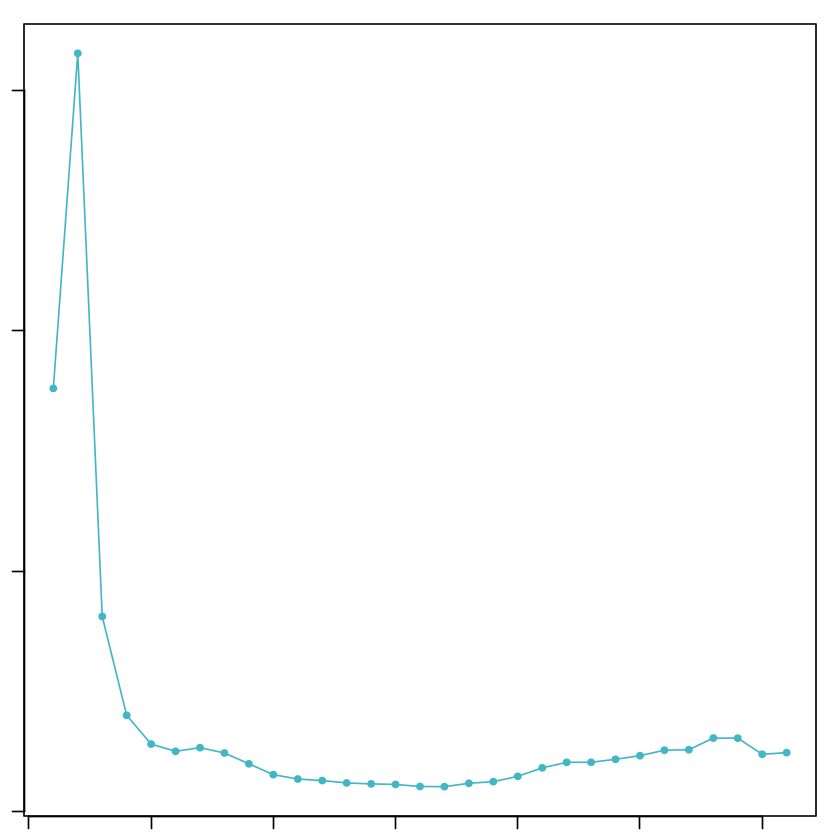

[1] "Creating 1388 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.8,seurat_clusters,pANN_0.25_0.01_281,DF.classifications_0.25_0.01_281
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>
AAACCTGAGCGTAGTG-1,SCLC,5191,2420,3.37121942,0.0007310139,0.121513035,G2M,SCLC,-0.120782021,1,1,0.12500000,Singlet
AAACCTGAGCGTGAAC-1,SCLC,1234,724,3.48460292,-0.1001472633,0.041424437,G2M,SCLC,-0.141571700,15,15,0.30357143,Doublet
AAACCTGCAAGCCATT-1,SCLC,3399,1720,3.58929097,-0.2308804108,-0.174718388,G1,SCLC,-0.056162023,0,0,0.16071429,Singlet
AAACCTGGTCGGCACT-1,SCLC,7160,2427,0.83798883,-0.2501822531,-0.388665370,G1,SCLC,0.138483117,0,0,0.33928571,Doublet
AAACCTGTCAACCATG-1,SCLC,2710,1579,4.39114391,-0.1353276477,-0.162536215,G1,SCLC,0.027208567,2,2,0.01785714,Singlet
AAACCTGTCGGGAGTA-1,SCLC,567,217,4.05643739,-0.0497389961,-0.126676835,G1,SCLC,0.076937838,9,9,0.00000000,Singlet
AAACCTGTCTGTCTAT-1,SCLC,2170,1180,1.05990783,0.0840903970,-0.112130007,S,SCLC,0.196220404,3,3,0.08928571,Singlet
AAACGGGAGAATGTGT-1,SCLC,1238,824,0.08077544,-0.0988309998,-0.233477061,G1,SCLC,0.134646061,3,3,0.01785714,Singlet
AAACGGGAGATACACA-1,SCLC,4119,1877,3.20466133,0.0067383124,-0.324331790,S,SCLC,0.331070103,2,2,0.07142857,Singlet


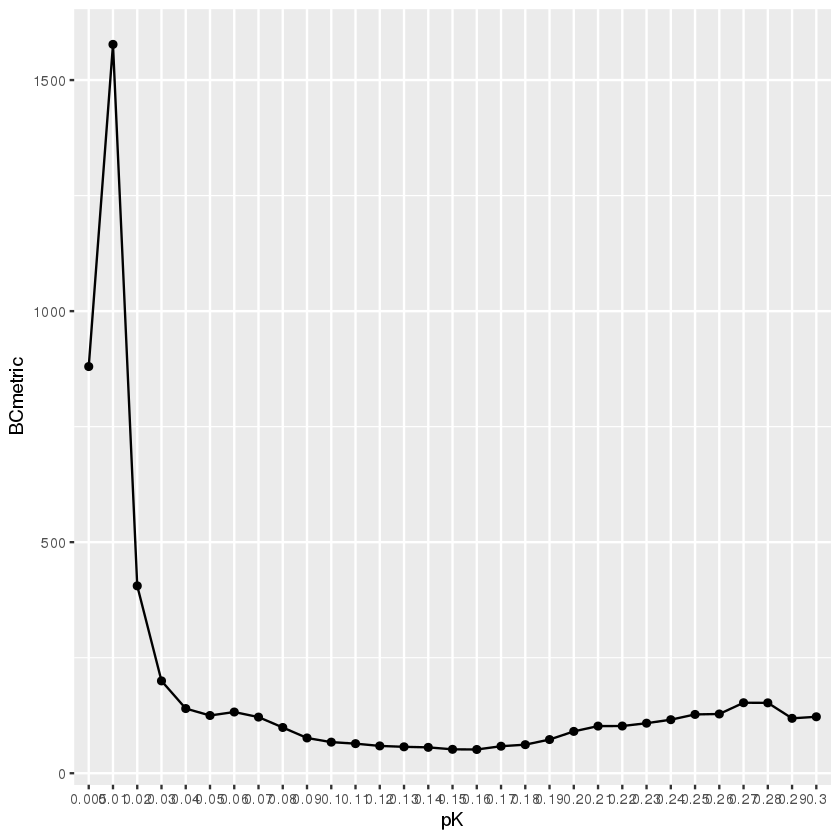

In [6]:
### we finished with data pre-processing prior to any doublet finder --- Now we can go for doublet finder 
### Important points - 1. Doublet finder needs to be done on each sample separately, prior to aggregating 
## pk identification --- no ground truth approach
# link -- https://rdrr.io/github/chris-mcginnis-ucsf/DoubletFinder/man/doubletFinder_ParamSweep.html
# link - https://www.youtube.com/watch?v=NqvAS4HgmrE
## required packages 
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
#library(DoubletFinder)

## step 13. Doublet Finding
sweep.list_SCAF3163 <- paramSweep_v3(dat_seurat_obj_filtered, PCs =1:20, sct=FALSE)
sweep.stats_SCAF3163 <- summarizeSweep(sweep.list_SCAF3163, GT = FALSE)
bcmvn_SCAF3163 <- find.pK(sweep.stats_SCAF3163)

### plotting the results --- highest value in plot is your optimal pK
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/optimal_k.jpg", width = 3000, height = 2000, res=300)
ggplot(bcmvn_SCAF3163, aes(pK, BCmetric, group=1))+
geom_point()+
geom_line()
dev.off()


### storing the highest pk value to a pk variable
pK <- bcmvn_SCAF3163 %>%
      filter(BCmetric == max(BCmetric)) %>%
      select(pK)
pK <- as.numeric(as.character(pK[[1]]))


### Homotypic doublet proprotion estimation
annotations <- dat_seurat_obj_filtered@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)
nExp_poi <- round(0.076*nrow(dat_seurat_obj_filtered@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))


#### run Doubletfinder 
dat_seurat_obj_filtered <- doubletFinder_v3(dat_seurat_obj_filtered, PCs = 1:20, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
## Viewing data frame 
View(dat_seurat_obj_filtered@meta.data)

In [7]:
# before plotting we need to see following items in our data
names(dat_seurat_obj_filtered@meta.data)
# from there we got the DF.classification, which we need for plot
# homotypic.prop
nExp_poi ## number of expected doublets
nExp_poi.adj ## number of actual doublets

[1] "orig.ident"                       "nCount_RNA"                      
 [3] "nFeature_RNA"                     "percent.mt"                      
 [5] "S.Score"                          "G2M.Score"                       
 [7] "Phase"                            "old.ident"                       
 [9] "CC.Difference"                    "RNA_snn_res.0.8"                 
[11] "seurat_clusters"                  "pANN_0.25_0.01_281"              
[13] "DF.classifications_0.25_0.01_281"

[1] 317

[1] 281

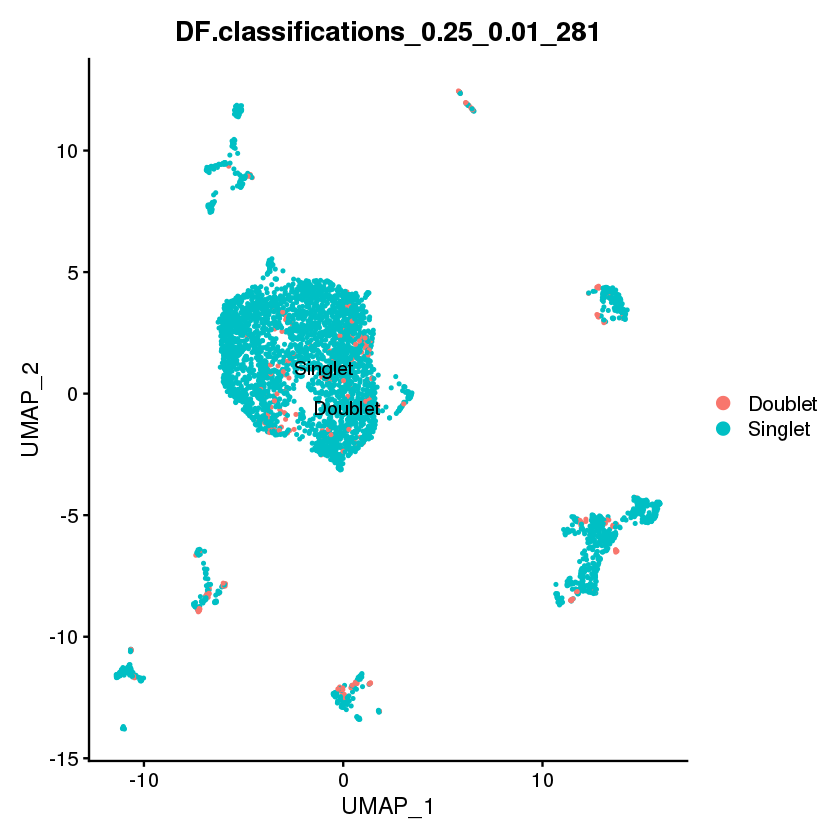

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.409116e-90,1.1158113,0.924,0.683,3.524762e-86,0,GRP
8.455324e-71,0.8958694,0.912,0.637,2.115015e-66,0,COL1A2
1.022563e-135,1.6543705,0.861,0.381,2.557839e-131,1,HIST1H1E
7.203664e-184,1.3567689,0.743,0.164,1.801925e-179,1,RRM2
3.002299e-31,1.2843168,0.663,0.424,7.509950e-27,2,ARL6IP1
4.549621e-22,1.0520180,0.289,0.138,1.138042e-17,2,CCNB1
4.174064e-10,0.8507021,0.488,0.452,1.044100e-05,3,KRT8
2.074785e-36,0.7537230,0.849,0.859,5.189868e-32,3,COTL1
5.178996e-82,1.9055272,0.832,0.465,1.295474e-77,4,HIST1H4C


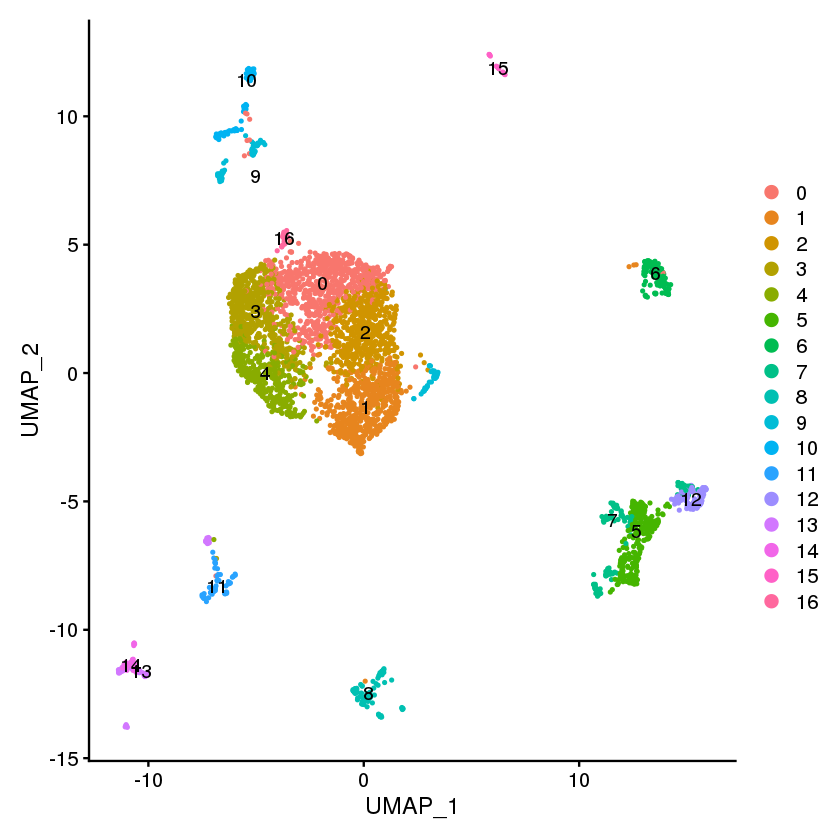

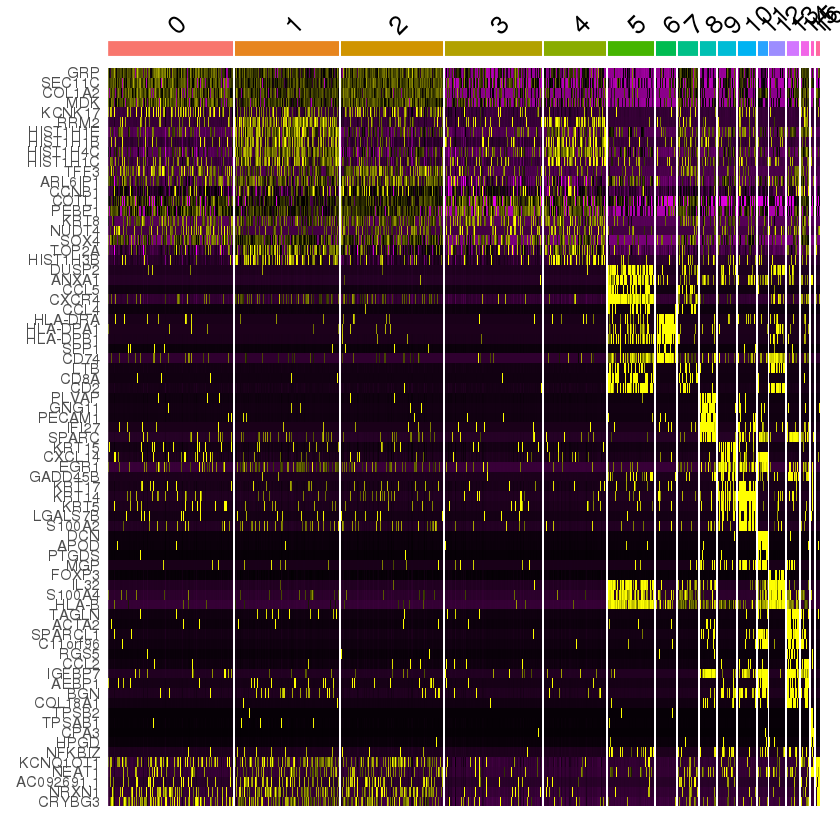

In [8]:
### visulaize the doublets 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_281")
dev.off()

## Step 13. Doublets removal
#since we have the name doublets in one of our meta data column of a "dat_seurat_obj_filtered@meta_data", this column has singlet and doublet information
#we can only select singlet by specifying values and so
#Link --- https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/seurat/seurat_01_qc.html
#data.filt = data.filt[, data.filt@meta.data[, DF.name] == "Singlet"]
data.filt = dat_seurat_obj_filtered[, dat_seurat_obj_filtered@meta.data[, "DF.classifications_0.25_0.01_281"] == "Singlet"]
#dim(data.filt)

### ploting the doublet removed dataset for PC & UMAP
#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/UMAP_doublets_removed.jpg", width = 3000, height = 2000, res=300)
#DimPlot(data.filt, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_287")
#dev.off()


### plotting the doublet removed dataset with cluster info 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/without_doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(data.filt, reduction = "umap", label = TRUE)
dev.off()


## step 14. Finding differentially expressed features (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
# saving all the markers genes
write.csv(dat_filt.markers, file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/positive_marker_gene.csv")
# saving markers genes for a defined crieria
sub_df <- subset(dat_filt.markers, avg_log2FC > 2 & p_val < 0.05)
write.csv(sub_df, file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/positive_marker_gene_significant.csv")
# plotting the marker gene 
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/top5_markers.jpg", width = 5500, height = 3300, res=300)
dat_filt.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5
DoHeatmap(data.filt, features = top5$gene) + NoLegend()
dev.off()


Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
"The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application."
Warning message:
"The following arguments are not used: scale.factor"
Centering and scaling data matrix

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 4 sub-sample(s) of approximately 971 cells each using 1 / 1 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signa

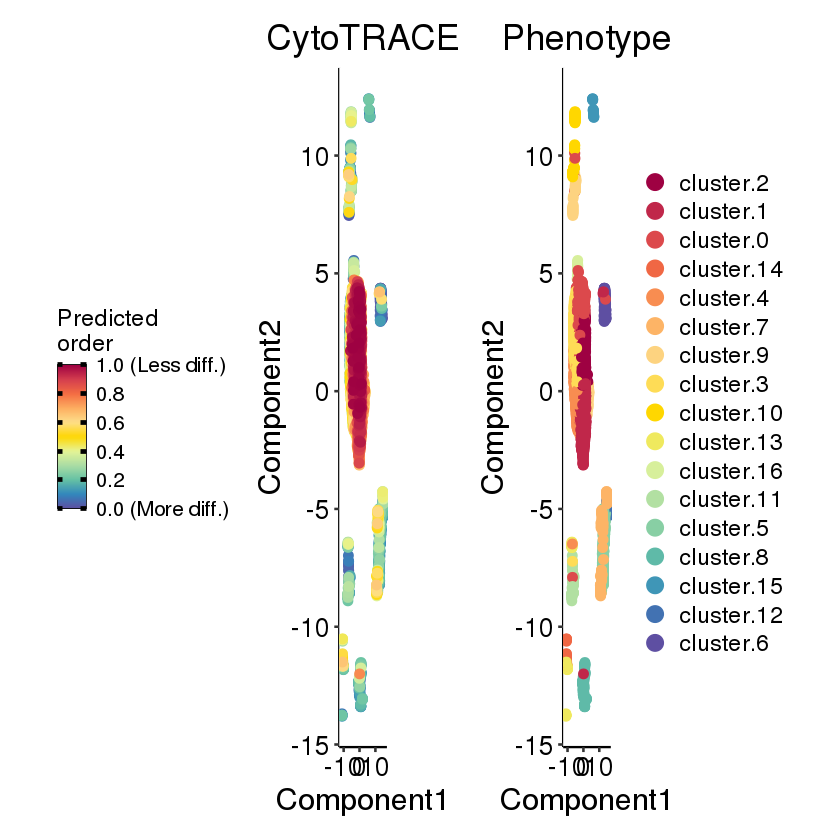

In [9]:
#### Cyotrace analysis starts from here ####
# Link - https://cytotrace.stanford.edu/
####
#install.packages("devtools")
#devtools::install_local("/data/kumarr9/CytoTRACE_0.3.3.tar.gz")
library(CytoTRACE)
#### Cyotrace needs the normalized seurat object
# mtrx should be non-negative(?) => seurat_obj should be normalized using scale.factor=1e6 instead of default (1e5)
seurat_obj <- ScaleData(data.filt, scale.factor=1e6 )
# seurat_obj <- RunPCA(seurat_obj)
# seurat_obj <- JackStraw(seurat_obj)
# seurat_obj <- ScoreJackStraw(seurat_obj)
# seurat_obj <- FindClusters(seurat_obj)
mtrx <- FetchData(seurat_obj, vars=rownames(seurat_obj))
mtrx <- t(mtrx)
## remove genes with 0 reads (of the genes included)
 genes.w.reads <- names(rowSums(mtrx)[rowSums(mtrx)>0])
 mtrx <- mtrx[genes.w.reads,]

 mtrx <- data.frame(mtrx)
 mtrx[mtrx=='.'] <- 0

# ##  outputs a list that includes CytoTRACE score per cell
 Cytotrace.out <- CytoTRACE(mtrx)

 meta <- paste0('cluster.', seurat_obj$seurat_clusters)
 names(meta) <- colnames(seurat_obj)
 names(meta) <- str_replace(names(meta), '-', '.')

# ## UMAP embeddings from Seurat
 umap.embeddings <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
 row.names(umap.embeddings) <- str_replace(row.names(umap.embeddings), '-', '.')

 cytotrace.plots <- plotCytoTRACE(Cytotrace.out, emb = umap.embeddings, phenotype = meta, outputDir = '/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/CytoTRACE.output.data')

In [11]:
#### Getting NE, Non-NE gene expression within each cluster of seurat object ####

# Provide a list of genes whose expression you want to see within each cluster
sclc_ne_genes <- c("ASCL1", "BEX1", "BSN", "CELF3", "CHGA", "CHGB","CRMP1", "FAM57B", "INSM1", "KIF1A", 
                   "KIF5C", "MYT1", "RTN1", "RUNDC3A", "SCG3","SEZ6", "SH3GL2", "SYN1", "SYP", "SYT11", 
                    "SYT4", "TAGLN3" ,"TFF3", "TMSB15A", "TMSB15B")
sclc_non_ne_genes <- c("ABCC3", "AHNAK", "ANXA1", "ARHGDIB", "CAV1","CAV2", "CCND1", "CYR61", "EMP1", "EPHA2",
                        "IFITM2", "IFITM3", "ITGB4", "LGALS3", "MYOF","PLAU", "PTGES", "RAB27B", "S100A10", "S100A16",
                        "SLC16A5", "TACSTD2", "TGFBI", "TGFBR2", "YAP1")

# Use the marker genes for each cluster identified in previous steps -
#dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_ne_genes),
                                   ctrl = 20,
                                   name = "NE_genes_expression"
                                   )

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_non_ne_genes),
                                   ctrl = 20,
                                   name = "Non-NE_gene_expression"
                                   )

Warning message:
"The following features are not present in the object: FAM57B, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: CYR61, not searching for symbol synonyms"
Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Non.NE_gene_expression1; see ?make.names for more details on syntax validity"


In [12]:
#Getting NE expression data
gene_data <- seurat_obj@meta.data$NE_genes_expression1
cluster_info <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info <- as.numeric(cluster_info)
data_df <- cbind(gene_data, cluster_info)
data_df <- as.data.frame(data_df)
#data_df <- data.frame(gene_data, cluster_info)
# Set the plot title and y-axis label
plot_title <- "NE gene expression"
y_axis_label <- "Expression"

# Create the violin/box plot
png("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF2221/alternate/new_cytotrace/NE_NonNE.jpg", width = 3000, height = 1500, res=300)
library(ggplot2)
ne <- ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, col = factor(cluster_info)), add = "jitter") + 
  geom_boxplot(scale = "width") +
  ggtitle(plot_title) + 
  xlab("Cluster") + theme_classic() +
  ylab(y_axis_label) + geom_hline(yintercept=0.00, linetype="dashed", color = "red")

#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/NE.jpg", width = 3000, height = 2000, res=300)

#Getting Non_NE expression data
gene_data2 <- seurat_obj@meta.data$Non.NE_gene_expression1
cluster_info2 <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info2 <- as.numeric(cluster_info2)
data_df2 <- cbind(gene_data2, cluster_info2)
data_df2 <- as.data.frame(data_df2)
#data_d2f <- data.frame(gene_data2, cluster_info2)
# Set the plot title and y-axis label
plot_title2 <- "Non_NE gene expression"
y_axis_label <- "Expression"
# Create the violin/box plot
non_ne <- ggplot(data_df2, aes(x = factor(cluster_info2), y = gene_data2, col = factor(cluster_info2)), add = "jitter") + 
  geom_boxplot(scale = "width") +
  ggtitle(plot_title2) + 
  xlab("Cluster") + theme_classic() +
  ylab(y_axis_label) + geom_hline(yintercept=0.00, linetype="dashed", color = "red")

NE_NonNE <- ne + non_ne
NE_NonNE
dev.off()

Warning message in geom_boxplot(scale = "width"):
"Ignoring unknown parameters: `scale`"
Warning message in geom_boxplot(scale = "width"):
"Ignoring unknown parameters: `scale`"


png 
  2

In [43]:
saveRDS(seurat_obj, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/SCAF3163_cell_cycle_regress_difference_out.rds")

In [5]:
####################################################################
#### Working with saved object to create InferCNV plots and so #####
####################################################################

#### trying working with seurat object ---
## trying InferCNV from the saved .rds file
SCAF3163 <- readRDS("/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/SCAF3163_cell_cycle_regress_difference_out.rds")
load("/data/kumarr9/scRNA/PBMC_seu.RData")





In [8]:
## step 16. mergind the two seurat object 
# link - https://satijalab.org/seurat/articles/merge_vignette.html
# We are merging based on normalized one and hence added the parameters of merge.data=TRUE
SCAF3163_merged <- merge(SCAF3163, y = PBMC_seu, add.cell.ids = c("SCLC", "PBMC"), project = "SCLC",
     merge.data = TRUE)
# to see the content of merged object
# SCAF3163_merged@assays$RNA@counts
# dim(SCAF3163_merged)
# dim(SCAF3163)
# dim(PBMC_seu)

## step 17. Getting count matrix from merged dataframe
#str(SCAF3163_merged)
expr_matrix <- GetAssayData(object = SCAF3163_merged, slot = "counts", assay = "RNA")
# converting the expr_matrix which is dgCmatrix to dataframe 
expr_df <- as.data.frame(expr_matrix)
#expr_df[1:20, 1:20]
write.table(expr_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/SCAF_matrix.csv", sep = "\t", row.names = TRUE, col.names = TRUE)


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.2 GiB"


In [9]:
### creating gene order matrix for infercnv 
gene_names <- rownames(SCAF3163_merged)
### converted it to dataframe 
gene_names <- data.frame(gene_names)
## adding chromosme number, start and end to it
## read a gtf file ----
gtf_file <- read.table("/data/SCLCgenomics/rajesh/gene_version_27_cp.gtf")
matching_rows <- gtf_file[gtf_file$V5 %in% gene_names$gene_names, ]
### correcting this dataframe as given in inferCNV package
gene_df <- matching_rows %>% 
  select(V5, everything())
gene_df <- gene_df[, -5]
gene_df = gene_df[!duplicated(gene_df$V5),]
# names(gene_df)[2] <- "chr"
# names(gene_df)[3] <- "start"
# names(gene_df)[4] <- "stop"

###
write.table(gene_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/gene_order.txt", sep = "\t", row.names = FALSE, col.names = FALSE)

In [10]:
## getting the cluster info from the seurat object/merged object
clust_info <- SCAF3163_merged@meta.data[, "seurat_clusters", drop=F]
## making dataset what looks like or needed by the inferCNV
clust_info$cellID <- rownames(clust_info)
clust_info$clstr <- paste0('cluster.', clust_info$seurat_clusters)
clust_info_df <- clust_info[, !names(clust_info) %in% "seurat_clusters"]
write.table(clust_info_df, file = "/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/annotation.txt", sep = "\t", row.names = FALSE, col.names = FALSE)

In [11]:
# creating infercnv object
## Modification you need to do before creating object --
#1. Open the annotation.txt file and replace the PBMC cluster with PBMC only 
SCAF3163_infercnv_obj = CreateInfercnvObject(raw_counts_matrix="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/SCAF_matrix.csv",
                                    annotations_file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/annotation.txt",
                                    gene_order_file="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/gene_order.txt",
                                    ref_group_names=c("PBMC"))

INFO [2023-05-18 08:38:50] Parsing matrix: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/SCAF_matrix.csv
INFO [2023-05-18 08:40:21] Parsing gene order file: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/gene_order.txt
INFO [2023-05-18 08:40:22] Parsing cell annotations file: /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/annotation.txt
INFO [2023-05-18 08:40:22] ::order_reduce:Start.
INFO [2023-05-18 08:40:25] .order_reduce(): expr and order match.
INFO [2023-05-18 08:40:26] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 60029,7256 Total=22273621 Min=0 Max=3089.
INFO [2023-05-18 08:40:28] num genes removed taking into account provided gene ordering list: 6401 = 10.6631794632594% removed.
INFO [2023-05-18 08:40:28] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2023-05-18 08:40:31] Please use "options(scipen = 100)" before running infercnv if you

In [12]:
# perform infercnv operations to reveal cnv signal
infercnv_obj2 = infercnv::run(SCAF3163_infercnv_obj,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                             out_dir="/data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/infercnv_results",  # dir is auto-created for storing outputs
                             cluster_by_groups=T,   # cluster
                             denoise=T,
                             HMM=T
                             )

INFO [2023-05-18 09:30:53] ::process_data:Start
INFO [2023-05-18 09:30:53] Checking for saved results.
INFO [2023-05-18 09:30:53] 

	STEP 1: incoming data

INFO [2023-05-18 09:31:35] 

	STEP 02: Removing lowly expressed genes

INFO [2023-05-18 09:31:35] ::above_min_mean_expr_cutoff:Start
INFO [2023-05-18 09:31:36] Removing 49755 genes from matrix as below mean expr threshold: 0.1
INFO [2023-05-18 09:31:37] validating infercnv_obj
INFO [2023-05-18 09:31:37] There are 3873 genes and 7256 cells remaining in the expr matrix.
INFO [2023-05-18 09:31:38] no genes removed due to min cells/gene filter
INFO [2023-05-18 09:31:47] 

	STEP 03: normalization by sequencing depth

INFO [2023-05-18 09:31:47] normalizing counts matrix by depth
INFO [2023-05-18 09:31:48] Computed total sum normalization factor as median libsize: 2292.500000
INFO [2023-05-18 09:31:50] Adding h-spike
INFO [2023-05-18 09:31:50] -hspike modeling of PBMC
INFO [2023-05-18 09:32:59] validating infercnv_obj
INFO [2023-05-18 09:3

Centering and scaling data matrix

PC_ 1 
Positive:  HDAC2, MARCKS, AL050331.1, FYN, TSPYL1, FAM26F, REV3L, RWDD1, GTF3C6, AMD1 
	   AL450405.1, CDC40, ASF1A, CD164, SNX3, SERINC1, SEC63, CD24, HDDC2, ATG5 
	   CCNC, NCOA7, PNISR, CENPW, CASP8AP2, LYRM2, ECHDC1, RRAGD, PTPRK, UBE2J1 
Negative:  C19orf60, COPE, RFXANK, UBA52, NDUFA13, KXD1, ZNF101, BLVRB, PLD3, SHKBP1 
	   FKBP8, ZNF430, PSMC4, SNRPA, FBL, EGLN2, SUPT5H, ISYNA1, TIMM50, RPSAP58 
	   RPS16, DLL3, ZFP36, HNRNPUL1, UQCRFS1, SSBP4, MED29, TGFB1, POP4, PAF1 
PC_ 2 
Positive:  HMGN2, AL513365.1, CD52, ARID1A, SH3BGRL3, SFN, SYTL1, NUDC, WASF2, STMN1 
	   TMEM50A, DNAJC8, RSRP1, ATPIF1, SNHG3, SYF2, TRNAU1AP, RUNX3, TAF12, YTHDF2 
	   CLIC4, EPB41, SRRM1, SRSF4, RCAN3, LAPTM5, SRSF10, PUM1, PNRC2, PITHD1 
Negative:  EPB41L4A-AS1, SRP19, REEP5, NREP, CAMK4, DCP2, PJA2, PAM, ATG12, CHD1 
	   LNPEP, AP3S1, ERAP2, AC034236.1, CAST, COMMD10, PCSK1, TNFAIP8, GLRX, TTC37 
	   HSD17B4, ARRDC3, SNX2, MEF2C, HOOK3, FNTA, SMIM19, CEBPD, 

INFO [2023-05-18 09:41:59] define_signif_tumor_subclusters(), tumor: cluster.1


Centering and scaling data matrix

PC_ 1 
Positive:  GZMA, GZMK, DHX29, NDUFS4, IL6ST, AC022431.1, MOCS2, ISL1, GPBP1, PARP8 
	   SMIM15, EMB, KIF2A, SREK1IP1, MRPS30, NNT, CENPK, NNT-AS1, ERBIN, PAIP1 
	   HMGCS1, SREK1, ZNF131, PIK3R1, ANXA2R, CCNB1, SELENOP, C5orf51, CENPH, OXCT1 
Negative:  RFXANK, COPE, NDUFA13, ZNF101, C19orf60, ZNF430, UBA52, RPSAP58, UQCRFS1, KXD1 
	   POP4, FKBP8, URI1, PDCD5, ISYNA1, PEPD, LSM14A, SSBP4, GPI, UBA2 
	   ZNF302, LSM4, GRAMD1A, FXYD5, JUND, LSR, IFI30, USF2, DMKN, CCDC124 
PC_ 2 
Positive:  SMARCA4, TMEM205, DNM2, ILF3-AS1, KEAP1, CDKN2D, SLC44A2, ILF3, PRKCSH, ECSIT 
	   CDC37, ELOF1, ICAM3, ZNF791, CEBPZ, PRKD3, MRPL4, QPCT, RPL10P16, CEBPZOS 
	   CDC42EP3, DNMT1, EIF2AK2, RPLP0P6, WDR83OS, EIF3G, BIRC6, DHPS, HNRNPLL, PIN1 
Negative:  YIPF5, NR3C1, HDAC3, LARS, DIAPH1, NDFIP1, TAF7, TCERG1, ZMAT2, HARS 
	   DPYSL3, IK, NDUFA2, JAKMIP2, CD14, CSNK1A1, SRA1, RPL7P1, ANKHD1, TCOF1 
	   PFDN1, CD74, CYSTM1, PURA, RPS14, CXXC5, RBM22, UBE2D2, DCTN

INFO [2023-05-18 09:42:02] define_signif_tumor_subclusters(), tumor: cluster.10


Centering and scaling data matrix

PC_ 1 
Positive:  GOLGA4, EPM2AIP1, PDCD6IP, RPSA, CRTAP, CMTM6, EIF1B, CMTM7, RPL14, STT3B 
	   CTNNB1, SS18L2, NKTR, TMEM158, CCDC12, SETD2, SMARCC1, DHX30, MAP4, TMA7 
	   SHISA5, UQCRC1, IP6K2, ARIH2, NDUFAF3, IMPDH2, QARS, GPX1, RHOA, RBM6 
Negative:  GRP, SEC11C, LMAN1, PMAIP1, MALT1, BCL2, KDSR, NARS, VPS4B, CYB5A 
	   TXNL1, TCF4, AC008021.1, MBD2, CNDP2, MEX3C, SMAD4, SOX2, DCUN1D1, PPP2R5C 
	   DNAJC19, PARL, KLHL24, AC131235.1, FXR1, AP2M1, DVL3, TTC14, CAMK2N2, ME2 
PC_ 2 
Positive:  TMBIM6, SMARCD1, COX14, ATF1, MCRS1, LETMD1, DAZAP2, SPATS2, TUBA1C, BIN2 
	   TUBA1A, NR4A1, AC011603.2, KRT7, KRT5, TUBA1B, KRT8, ARF3, KRT18, FKBP11 
	   EIF4B, TMEM106C, PFDN5, EXOSC1, PGAM1, RPL13AP5, HPS1, LCOR, C12orf10, TM9SF3 
Negative:  ALDH7A1, AC113398.1, PHAX, SNX2, LMNB1, HSD17B4, AC113367.1, TNFAIP8, HINT1, CDC42SE2 
	   COMMD10, FNIP1, VDAC1, IRF1, HSPA4, C5orf15, ZCCHC10, UQCRQ, AFF4, TCF7 
	   AC034236.1, SKP1, PPP2CA, UBE2B, CAMLG, AP3S1, DD

INFO [2023-05-18 09:42:03] define_signif_tumor_subclusters(), tumor: cluster.11


Centering and scaling data matrix

PC_ 1 
Positive:  RPS4XP6, NIPBL, NUP155, WDR70, SKP2, RICTOR, IL7R, FYB1, DNAJC21, PTGER4 
	   BRIX1, RAD1, PRKAA1, RAI14, RPL37, OXCT1, TARS, AC010343.1, C5orf51, SUB1 
	   SELENOP, ZFR, ANXA2R, GK5, XRN1, ZNF131, PLSCR1, GOLPH3, U2SURP, GYG1 
Negative:  CAPNS1, ZNF146, TBCB, SPINT2, POLR2I, PSMD8, TYROBP, EIF3K, HCST, ACTN4 
	   LGALS7B, ECH1, APLP1, HNRNPL, PSENEN, SIRT2, MRPS12, GMFG, ERCC1, FOSB 
	   COX6B1, TRAPPC6A, PAF1, VASP, CLPTM1, APOE, MED29, SNRPD2, TOMM40, ZFP36 
PC_ 2 
Positive:  HMGN2, ARID1A, AL513365.1, SFN, RPA2, IFI6, CD52, DNAJC8, NUDC, SH3BGRL3 
	   FGR, SYTL1, ATPIF1, WASF2, STMN1, SNHG3, TRNAU1AP, TMEM50A, TAF12, RSRP1 
	   GNB1, SYF2, YTHDF2, RUNX3, EPB41, FAAP20, CLIC4, RER1, SRSF4, TNFRSF14 
Negative:  TSPYL1, REV3L, FYN, AL050331.1, FAM26F, GTF3C6, RWDD1, MARCKS, HDAC2, AL450405.1 
	   ASF1A, AMD1, SERINC1, CDC40, HDDC2, CD164, NCOA7, SNX3, CENPW, SEC63 
	   CD24, ECHDC1, ATG5, CCNC, PTPRK, PNISR, SAMD3, CASP8AP2, STX7, L

INFO [2023-05-18 09:42:04] define_signif_tumor_subclusters(), tumor: cluster.12


Centering and scaling data matrix

PC_ 1 
Positive:  CIR1, OLA1, AC016739.1, ATP5G3, WIPF1, MTX2, SP3, HNRNPA3, NFE2L2, ITGA6 
	   HAT1, PRKRA, DYNC1I2, UBE2E3, AC007969.1, ITGA4, TLK1, DNAJC10, GORASP2, NCKAP1 
	   METTL5, ZC3H15, SSB, ORMDL1, KLHL23, PPIG, GLS, AC107075.1, STAT1, GCA 
Negative:  TRNAU1AP, SNHG3, ATPIF1, TAF12, DNAJC8, YTHDF2, RPA2, EPB41, IFI6, SRSF4 
	   RPAIN, C1QBP, DERL2, FGR, TXNDC17, LAPTM5, WASF2, SYTL1, HMGN2, SFN 
	   ARID1A, NUDC, AL513365.1, RNASEK, PUM1, CD52, SNRNP40, ZCCHC17, SH3BGRL3, C17orf49 
PC_ 2 
Positive:  PCBP2, ATP5G2, HNRNPA1, CALCOCO1, PRR13, CBX5, COPZ1, NCKAP1L, C12orf10, DCD 
	   PFDN5, MUCL1, CD63, BLOC1S1, EIF4B, SARNP, RAB5B, CDK2, RPS26, PYM1 
	   PA2G4, RPL41, ESYT1, MYL6B, KRT18, MYL6, KRT8, SMARCC2, KRT5, NABP2 
Negative:  CEP95, PECAM1, SNHG25, DDX5, CD79B, SMARCD2, ICAM2, HELZ, PSMC5, DDX42 
	   PSMD12, PITPNC1, CCDC47, NOL11, LIMD2, DCAF7, VMP1, BPTF, CLTC, KPNA2 
	   DHX40, AMZ2, SKA2, PRKAR1A, RAD51C, SOX9, SUPT4H1, RPL38, SLC9

INFO [2023-05-18 09:42:05] define_signif_tumor_subclusters(), tumor: cluster.13


Centering and scaling data matrix

PC_ 1 
Positive:  HSD17B11, SPARCL1, MRPS18C, PLAC8, SEC31A, SPP1, ENOPH1, PYURF, HNRNPDL, EIF4E 
	   HNRNPD, CCNI, ADH5, G3BP2, DNAJB14, PPBP, PF4, DCK, GRSF1, JCHAIN 
	   YTHDC1, CENPC, IGFBP7, POLR2B, REST, HOPX, SRP72, PAICS, TMEM165, RPSA 
Negative:  GRP, PMAIP1, LMAN1, BCL2, SEC11C, KDSR, VPS4B, MALT1, CYB5A, NARS 
	   AC008021.1, CNDP2, TXNL1, TCF4, MBD2, MEX3C, SMAD4, ME2, C5orf22, DROSHA 
	   FTH1P10, GOLPH3, ZFR, CXXC1, BASP1, MYO10, SUB1, RETREG1, ZNF622, ACAA2 
PC_ 2 
Positive:  CSRP1, IPO9, TMEM9, TIMM17A, PTPRC, RNPEP, CDC73, ELF3, UBE2T, RGS2 
	   KDM5B, AL136454.1, ADIPOR1, RGS1, CYB5R1, TMEM183A, RGS18, BTG2, SNRPE, TPR 
	   AL592114.1, MDM4, IVNS1ABP, ELK4, NUCKS1, RASSF5, ARPC5, AL591846.1, XRN1, GK5 
Negative:  URM1, SPTAN1, TMSB4XP4, WDR34, SET, COQ4, CIZ1, ZDHHC12, C9orf16, SH3GLB2 
	   DPM2, C9orf78, AK1, FNBP1, FPGS, ASS1, RPL12, FUBP3, MAPKAP1, RPS19 
	   NUP214, TGFB1, CD79A, ARHGEF1, HNRNPUL1, HSPA5, EGLN2, RABAC1, PRRC2B, S

INFO [2023-05-18 09:42:06] define_signif_tumor_subclusters(), tumor: cluster.14


Centering and scaling data matrix

PC_ 1 
Positive:  CTNNA1, PAIP2, HSPA9, TMEM173, ETF1, EGR1, UBE2D2, FAM13B, HNRNPA0, CXXC5 
	   SMAD5, CXCL14, PURA, H2AFY, C5orf24, DDX46, CYSTM1, CAMLG, UBE2B, PFDN1 
	   PPP2CA, SKP1, ANKHD1, TCF7, SRA1, CD14, TMPO, TMPO-AS1, SLC25A3, CHPT1 
Negative:  SF3B2, RAB1B, YIF1A, BANF1, BRMS1, SART1, MRPL11, RBM14, DRAP1, RBM4 
	   KDM2A, GRK2, CCDC85B, POLD4, FIBP, PPP1CA, TBC1D10C, CTSW, RPS6KB2, CORO1B 
	   CFL1, TMEM134, RNASEH2C, AIP, CDK2AP2, RELA, GSTP1, MALAT1, NDUFV1, NEAT1 
PC_ 2 
Positive:  ARHGEF7, ANKRD10, PCID2, TNFSF13B, CUL4A, ARGLU1, EIF5B, TPP2, REV1, LAMP1 
	   TXNDC9, PDCL3, ZIC2, MITD1, RPL31, TFDP1, TM9SF2, MGAT4A, RNF149, GAS6 
	   ZAP70, MAP4K4, GPR183, NCK2, UPF3A, COX5B, UBAC2, ANKRD36, GCC2, STK24 
Negative:  CMSS1, CLDND1, NIT2, CRYBG3, TOMM70, MTRNR2L12, TFG, CGGBP1, CHMP2B, TRMT10C 
	   PPP4R2, FOXP1, PCNP, ARL6IP5, TMF1, PSMD6, THOC7, C3orf14, AC096919.1, PDHB 
	   ARF4, PDCD4, BBIP1, SMC3, APPL1, SMNDC1, SHOC2, ADD3, CCDC1

INFO [2023-05-18 09:42:07] define_signif_tumor_subclusters(), tumor: cluster.15
INFO [2023-05-18 09:42:07] Less cells in group cluster.15 than k_nn setting. Keeping as a single subcluster.
INFO [2023-05-18 09:42:07] define_signif_tumor_subclusters(), tumor: cluster.16


Centering and scaling data matrix

PC_ 1 
Positive:  RFXANK, NDUFA13, ZNF101, COPE, C19orf60, ZNF430, UBA52, RPSAP58, KXD1, UQCRFS1 
	   FKBP8, POP4, ISYNA1, URI1, SSBP4, PDCD5, LSM4, PEPD, JUND, LSM14A 
	   IFI30, GPI, CCDC124, UBA2, RPL18A, ZNF302, GRAMD1A, PGLS, FXYD5, LSR 
Negative:  PARP8, ISL1, EMB, NNT, PAIP1, NNT-AS1, HMGCS1, MRPS30, MOCS2, ZNF131 
	   ANXA2R, SELENOP, C5orf51, OXCT1, RPL37, NDUFS4, PRKAA1, PTGER4, GZMK, FYB1 
	   GZMA, RICTOR, WDR70, DHX29, NUP155, IL6ST, RPS4XP6, AC022431.1, NIPBL, SKP2 
PC_ 2 
Positive:  SP100, ITM2C, PSMD1, SP110, NCL, TRIP12, PTMA, MFF, EIF4E2, CUL3 
	   INPP5D, DNPEP, TUBA4A, ARL4C, ZFAND2B, SH3BP4, RRM1, RHOG, ZNF195, RETREG2 
	   COPS8, NAP1L4, HBB, CDKN1C, CNOT9, HBG2, KCNQ1OT1, TSSC4, CTDSP1, TRIM22 
Negative:  UCP2, AP001324.1, RAB6A, MRPL48, RPS3, SPCS2, COA4, ANAPC15, LAMTOR1, THAP12 
	   NUMA1, MRPL21, CLNS1A, KMT5B, NDUFS8, RSF1, ATP5G2, PCBP2, PRR13, CALCOCO1 
	   C12orf10, PFDN5, CBX5, HNRNPA1, NDUFV1, EIF4B, KRT18, COPZ1, KRT8

INFO [2023-05-18 09:42:07] define_signif_tumor_subclusters(), tumor: cluster.2


Centering and scaling data matrix

PC_ 1 
Positive:  CLDN3, CLDN4, BUD23, EIF4H, BCL7B, RFC2, BAZ1B, GTF2I, RHBDD2, CASTOR2 
	   SPG21, PDCD7, OAZ2, MDH2, HACD3, HSPB1, NSUN5, PCLAF, PPIB, YWHAG 
	   RAB11A, FGL2, STAG3L3, SNX1, RSBN1L, MAP2K1, CACNA2D1, DMTF1, FAM96A, AUTS2 
Negative:  RCAN3, SRRM1, SRSF10, CLIC4, PNRC2, RUNX3, PITHD1, SYF2, RPL11, RSRP1 
	   ID3, TMEM50A, TCEA3, STMN1, HNRNPR, SH3BGRL3, CD52, KDM1A, AL513365.1, CDC42 
	   HMGN2, HP1BP3, ARID1A, SFN, CDC20, DDOST, ATP6V0B, ERI3, EBNA1BP2, RNF220 
PC_ 2 
Positive:  HDGFL2, SHD, MYDGF, MAP2K2, UHRF1, ZBTB7A, SAFB2, EEF2, SAFB, MATK 
	   RPL36, MRPL54, HMG20B, NFIC, C19orf70, S1PR4, AES, NDUFA11, TLE2, CLPP 
	   SLC39A3, ALKBH7, GADD45B, TIMM13, GTF2F1, LSM7, ZNF358, OAZ1, XAB2, SF3A2 
Negative:  AMOTL2, ANAPC13, RYK, TOPBP1, CEP63, PCCB, CDV3, STAG1, TMEM108, NCK1 
	   UBA5, MRPL3, ARMC8, H1FX, MBD4, ATP2C1, HMCES, COPG1, CEP70, CNBP 
	   MRPS22, COPB2, ISY1, SLC25A36, RASA2, RBP1, RAB7A, RNF7, RPN1, ATP1B3 
PC_ 3 
Posi

INFO [2023-05-18 09:42:10] define_signif_tumor_subclusters(), tumor: cluster.3


Centering and scaling data matrix

PC_ 1 
Positive:  GZMA, DHX29, GZMK, IL6ST, NDUFS4, MOCS2, AC022431.1, ISL1, PARP8, EMB 
	   GPBP1, MRPS30, SMIM15, NNT, NNT-AS1, KIF2A, PAIP1, SREK1IP1, HMGCS1, ZNF131 
	   CENPK, ANXA2R, ERBIN, SELENOP, SREK1, C5orf51, PIK3R1, OXCT1, RPL37, CCNB1 
Negative:  CNFN, PAFAH1B3, ZNF428, GSK3A, POU2F2, TOMM40, RABAC1, APOE, ARHGEF1, CLPTM1 
	   CD79A, TRAPPC6A, RPS19, ERCC1, FOSB, VASP, TGFB1, SNRPD2, PPP5C, CALM3 
	   AP2S1, HNRNPUL1, TMEM160, EGLN2, SAE1, NAPA, NOP53, SELENOW, SNRPA, LIG1 
PC_ 2 
Positive:  KHDRBS1, EIF3I, PTP4A2, PEF1, ZCCHC17, LCK, SNRNP40, PUM1, MARCKSL1, HDAC1 
	   BSDC1, LAPTM5, ZBTB8OS, SRSF4, RBBP4, EPB41, SYNC, YARS, SMIM12, AK2 
	   PHC2, YTHDF2, SFPQ, TAF12, RPL5P4, TRNAU1AP, PSMB2, SNHG3, CLSPN, ATPIF1 
Negative:  RTN4, SPTBN1, ERLEC1, RPS27A, NRXN1, CFAP36, PPP4R3B, MSH6, FANCL, MSH2 
	   REL, EPCAM, CALM2, USP34, CRIPT, XPO1, PPM1B, CCT4, LRPPRC, ZFP36L2 
	   COMMD1, COX7A2L, EML4, MDH1, SRSF7, HNRNPLL, UGP2, RPLP0P6, RAB1A

INFO [2023-05-18 09:42:12] define_signif_tumor_subclusters(), tumor: cluster.4


Centering and scaling data matrix

PC_ 1 
Positive:  TSPYL1, FAM26F, AL050331.1, RWDD1, AMD1, HDAC2, GTF3C6, REV3L, FYN, CDC40 
	   MARCKS, AL450405.1, CD164, SNX3, SEC63, ATG5, CD24, CCNC, ASF1A, PNISR 
	   CASP8AP2, SERINC1, LYRM2, HDDC2, RRAGD, NCOA7, UBE2J1, CENPW, ECHDC1, PNRC1 
Negative:  PEPD, PDCD5, LSM14A, URI1, GPI, POP4, UBA2, ZNF302, UQCRFS1, RPSAP58 
	   GRAMD1A, ZNF430, ZNF101, FXYD5, NDUFA13, RFXANK, LSR, COPE, C19orf60, USF2 
	   ARHGEF1, CD79A, POU2F2, RABAC1, GSK3A, RPS19, UBA52, PAFAH1B3, DMKN, CNFN 
PC_ 2 
Positive:  CFL1, CTSW, RNASEH2C, FIBP, RELA, CCDC85B, MALAT1, NEAT1, DRAP1, DPF2 
	   SART1, CAPN1, FAU, BANF1, VPS51, SF3B2, ARL2, RAB1B, SF1, YIF1A 
	   RASGRP2, BRMS1, PRDX5, MRPL11, TRMT112, RBM14, BAD, PPP1R14B, RBM4, KDM2A 
Negative:  RPL23AP42, KPNA4, PDCD10, SMC4, MFSD1, AC074033.1, RSRC1, CCNL1, SEC62, TIPARP 
	   SSR3, PHC3, GMPS, DHX36, PSMD11, ZNF207, RHOT1, TMEM98, MBNL1, SKIL 
	   SUZ12, CCL2, COPRS, SIAH2, SLFN5, EVI2A, SELENOT, CLDN11, AP2B1, EVI2B

INFO [2023-05-18 09:42:14] define_signif_tumor_subclusters(), tumor: cluster.5


Centering and scaling data matrix

PC_ 1 
Positive:  AMOTL2, RYK, ANAPC13, TOPBP1, CEP63, PCCB, CDV3, TMEM108, MARCH6, CMBL 
	   DAP, CCT5, STAG1, UBA5, ZNF622, NSUN2, RETREG1, MYO10, MED10, MRPL3 
	   NCK1, BASP1, ICE1, ATP2C1, NDUFS6, ZNF639, ACTL6A, ARMC8, TBL1XR1, MBD4 
Negative:  FOSB, VASP, SNRPD2, ERCC1, PPP5C, CALM3, TRAPPC6A, AP2S1, TMEM160, SAE1 
	   CLPTM1, NAPA, NOP53, APOE, SELENOW, TOMM40, LIG1, ZNF428, CARD8, CNFN 
	   POU2F2, GSK3A, PAFAH1B3, RABAC1, EMP3, ARHGEF1, CD79A, KDELR1, RPS19, CYTH2 
PC_ 2 
Positive:  TMEM147, RBM42, COX6B1, PSENEN, APLP1, HCST, DMKN, TYROBP, USF2, POLR2I 
	   LSR, TBCB, FXYD5, GRAMD1A, CAPNS1, ZNF302, ZNF146, UBA2, SPINT2, GPI 
	   PSMD8, LSM14A, EIF3K, PEPD, PDCD5, ACTN4, URI1, LGALS7B, POP4, ECH1 
Negative:  TLK1, AC007969.1, GORASP2, DYNC1I2, METTL5, HAT1, ITGA6, SSB, SP3, OLA1 
	   KLHL23, CIR1, PPIG, WIPF1, AC107075.1, LRPPRC, PPM1B, ATP5G3, ZFP36L2, CRIPT 
	   COX7A2L, EML4, SRSF7, CALM2, GCA, HNRNPLL, AC016739.1, EPCAM, RPLP0P6, MSH2 


INFO [2023-05-18 09:42:16] define_signif_tumor_subclusters(), tumor: cluster.6


Centering and scaling data matrix

PC_ 1 
Positive:  HDAC1, MARCKSL1, LCK, BSDC1, EIF3I, KHDRBS1, PTP4A2, ZBTB8OS, PEF1, ZCCHC17 
	   RBBP4, SNRNP40, SYNC, PUM1, YARS, AK2, EPB41, SRSF4, LAPTM5, YTHDF2 
	   FGR, TAF12, PHC2, SYTL1, WASF2, NUDC, TRNAU1AP, IFI6, RPA2, ATPIF1 
Negative:  CD79A, ARHGEF1, RPS19, RABAC1, TGFB1, POU2F2, HNRNPUL1, EGLN2, GSK3A, SNRPA 
	   PAFAH1B3, SHKBP1, CNFN, BLVRB, ZNF428, TOMM40, PLD3, APOE, PSMC4, CLPTM1 
	   FBL, TRAPPC6A, DLL3, ERCC1, TIMM50, SUPT5H, FOSB, RPS16, VASP, ZFP36 
PC_ 2 
Positive:  HIST1H1E, HIST1H2AC, HIST1H1D, HIST1H4C, BTN3A2, HIST1H1C, ABT1, HIST1H3B, TRIM38, RIPOR2 
	   GMNN, C6orf62, TDP2, SOX4, AL512380.1, MYCBP2, KCTD12, COMMD6, RBM26, LINC00581 
	   DIS3, DNAJC3, MZT1, IPO5, FARP1, SUGT1, STK24, UBAC2, GPR183, CKAP2 
Negative:  RPL36, C19orf70, SAFB, NDUFA11, SAFB2, CLPP, UHRF1, MYDGF, ALKBH7, HDGFL2 
	   GTF2F1, SHD, ZNF358, MAP2K2, ZBTB7A, XAB2, EEF2, PET100, MATK, MRPL54 
	   STXBP2, HMG20B, NFIC, TRAPPC5, S1PR4, CTXN1, AES, TLE

INFO [2023-05-18 09:42:17] define_signif_tumor_subclusters(), tumor: cluster.7


Centering and scaling data matrix

PC_ 1 
Positive:  SPINT2, PSMD8, EIF3K, ZNF146, ACTN4, CAPNS1, LGALS7B, ECH1, TBCB, HNRNPL 
	   POLR2I, SIRT2, MRPS12, TYROBP, GMFG, HCST, PAF1, RAB11FIP1, EIF4EBP1, PPP2CB 
	   APLP1, LSM1, MED29, DCTN6, NSD3, DUSP4, CCDC25, LEPROTL1, TACC1, SARAF 
Negative:  NEAT1, MALAT1, DPF2, CAPN1, RELA, FAU, RNASEH2C, VPS51, CFL1, ARL2 
	   SF1, CTSW, RASGRP2, FIBP, CCDC85B, PRDX5, DRAP1, TRMT112, SART1, BAD 
	   BANF1, PPP1R14B, SF3B2, FKBP2, RAB1B, VEGFB, YIF1A, DNAJC4, BRMS1, NUDT22 
PC_ 2 
Positive:  AC064799.1, PKM, RPLP1, HEXA, ANP32A, ARIH1, PIAS1, ADPGK, UBL7, RPL4 
	   MAP2K1, CSK, RAB11A, SCAMP2, HACD3, COX5A, PDCD7, SPG21, OAZ2, COMMD4 
	   PCLAF, PPIB, SNX1, IMP3, FAM96A, USP3, UBE2Q2, RPS27L, TPM1, ETFA 
Negative:  KLHL24, DCUN1D1, PARL, SOX2, AC131235.1, DNAJC19, DVL3, FXR1, AP2M1, TTC14 
	   CAMK2N2, NDUFB5, PSMD2, EIF4G1, MRPL47, POLR2H, MAGEF1, ACTL6A, MAP3K13, TRA2B 
	   ZNF639, DNAJB11, TBL1XR1, EIF4A2, RFC4, ECT2, LPP, TNFSF10, CCDC50, FNDC3

INFO [2023-05-18 09:42:18] define_signif_tumor_subclusters(), tumor: cluster.8


Centering and scaling data matrix

PC_ 1 
Positive:  BCCIP, PTPRE, UROS, MKI67, MGMT, CTBP2, TUBGCP2, BNIP3, GLRX3, ZNF511 
	   OAT, ECHS1, BUB3, MTG1, PLEKHA1, NSMCE4A, MCMBP, TIAL1, RGS10, PRDX3 
	   EIF3A, RPL17P36, TRMT112, BAD, PRDX5, CACUL1, PPP1R14B, RASGRP2, CDIPT, SEZ6L2 
Negative:  BLVRB, PLD3, SHKBP1, PSMC4, SNRPA, FBL, DLL3, EGLN2, HNRNPUL1, TIMM50 
	   TGFB1, SUPT5H, RPS16, ZFP36, RPS19, MED29, CD79A, PAF1, GMFG, ARHGEF1 
	   MRPS12, RABAC1, SIRT2, HNRNPL, POU2F2, ECH1, LGALS7B, GSK3A, ACTN4, PAFAH1B3 
PC_ 2 
Positive:  KRT5, KRT8, KRT7, KRT18, NR4A1, BIN2, DAZAP2, EIF4B, LETMD1, ATF1 
	   PFDN5, COX14, SMARCD1, C12orf10, TMBIM6, PRR13, MCRS1, PCBP2, SPATS2, ATP5G2 
	   TUBA1C, CALCOCO1, TUBA1A, CBX5, HNRNPA1, AC011603.2, COPZ1, NCKAP1L, DCD, MUCL1 
Negative:  LNPEP, CHD1, ERAP2, PAM, CAST, PCSK1, PJA2, GLRX, CAMK4, TTC37 
	   ARRDC3, NREP, EPB41L4A-AS1, MEF2C, SRP19, CCNH, REEP5, COX7C, DCP2, ATG12 
	   AC034236.1, AP3S1, COMMD10, TNFAIP8, EDIL3, HSD17B4, SNX2, AC113398.1

INFO [2023-05-18 09:42:19] define_signif_tumor_subclusters(), tumor: cluster.9


Centering and scaling data matrix

PC_ 1 
Positive:  BASP1, MYO10, RETREG1, FTH1P10, ZNF622, DROSHA, DAP, C5orf22, MARCH6, GOLPH3 
	   CMBL, ZFR, CCT5, SUB1, NSUN2, MED10, ICE1, NDUFS6, AC010343.1, MRPL36 
	   TARS, LPCAT1, CLPTM1L, RAI14, BRD9, EXOC3, RAD1, PDCD6, SDHA, BRIX1 
Negative:  HSD17B11, SPARCL1, MRPS18C, PLAC8, SPP1, SEC31A, PYURF, ENOPH1, EIF4E, PPBP 
	   PF4, G3BP2, DCK, HNRNPDL, CCNI, HNRNPD, ADH5, GRSF1, RPSA, GOLGA4 
	   EIF1B, EPM2AIP1, DNAJB14, RPL14, PDCD6IP, JCHAIN, CTNNB1, CRTAP, SS18L2, YTHDC1 
PC_ 2 
Positive:  RPL18, BAX, NUCB1, FTL, PPP1R15A, CYTH2, KDELR1, RUVBL2, EMP3, SNRNP70 
	   CARD8, LIG1, PIH1D1, SELENOW, NOP53, NAPA, FCGRT, SAE1, PAFAH1B3, GSK3A 
	   TMEM160, CNFN, POU2F2, NOSIP, ZNF428, AP2S1, RABAC1, TOMM40, ARHGEF1, IRF3 
Negative:  CCDC186, SHOC2, BBIP1, RPL17P36, ABLIM1, PDCD4, CACUL1, SHTN1, FAM204A, EIF3A 
	   SMC3, PRDX3, SMNDC1, RGS10, ADD3, TIAL1, GSTO1, MCMBP, SLK, NSMCE4A 
	   USMG5, PLEKHA1, INA, BUB3, OAT, BORCS7, CTBP2, ARL3, UROS, ACTR

INFO [2023-05-18 09:42:20] define_signif_tumor_subclusters(), tumor: PBMC


Centering and scaling data matrix

PC_ 1 
Positive:  OXCT1, RPL37, C5orf51, SELENOP, PRKAA1, ANXA2R, PTGER4, ZNF131, FYB1, HMGCS1 
	   RICTOR, WDR70, PAIP1, NUP155, RPS4XP6, NNT-AS1, NIPBL, NNT, SKP2, IL7R 
	   MRPS30, DNAJC21, EMB, BRIX1, PARP8, ISL1, RAD1, MOCS2, RAI14, NDUFS4 
Negative:  SRGN, VPS26A, DDX21, HK1, DDX50, H2AFY2, SAR1A, CCAR1, NORAD, SCAND1 
	   HNRNPH3, MYL9, E2F1, ROMO1, CHMP4B, PPA1, PHF20, CBFA2T2, MAPRE1, RALY 
	   COMMD7, ASXL1, RBM39, CPNE1, TPX2, EIF2S2, APMAP, HM13, C20orf24, AHCY 
PC_ 2 
Positive:  SMC4, KPNA4, MFSD1, RPL23AP42, PDCD10, RSRC1, AC074033.1, CCNL1, SEC62, PHC3 
	   TIPARP, SKIL, SSR3, CLDN11, GMPS, RPL22L1, FNDC3B, DHX36, TNFSF10, MBNL1 
	   ECT2, SIAH2, SELENOT, TBL1XR1, EIF2A, SERP1, ZNF639, PFN2, RNF13, ACTL6A 
Negative:  SART1, BANF1, DRAP1, SF3B2, CCDC85B, RAB1B, FIBP, CTSW, YIF1A, BRMS1 
	   CFL1, MRPL11, RNASEH2C, RBM14, RELA, RBM4, KDM2A, MALAT1, GRK2, NEAT1 
	   POLD4, DPF2, PPP1CA, CAPN1, TBC1D10C, FAU, RPS6KB2, VPS51, CORO1B, ARL2 
P

INFO [2023-05-18 09:42:44] -mirroring for hspike
INFO [2023-05-18 09:42:44] define_signif_tumor_subclusters(p_val=0.1
INFO [2023-05-18 09:42:44] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_PBMC
INFO [2023-05-18 09:42:44] cut tree into: 1 groups
INFO [2023-05-18 09:42:44] -processing spike_tumor_cell_PBMC,spike_tumor_cell_PBMC_s1
INFO [2023-05-18 09:42:44] define_signif_tumor_subclusters(), tumor: simnorm_cell_PBMC
INFO [2023-05-18 09:42:44] cut tree into: 1 groups
INFO [2023-05-18 09:42:44] -processing simnorm_cell_PBMC,simnorm_cell_PBMC_s1
INFO [2023-05-18 09:43:46] ::plot_cnv:Start
INFO [2023-05-18 09:43:46] ::plot_cnv:Current data dimensions (r,c)=3873,7256 Total=28151396.0700761 Min=0.6831635212009 Max=2.6470819168103.
INFO [2023-05-18 09:43:47] ::plot_cnv:Depending on the size of the matrix this may take a moment.
INFO [2023-05-18 09:43:52] plot_cnv(): auto thresholding at: (0.812591 , 1.190890)
INFO [2023-05-18 09:44:20] plot_cnv_observation:Start
INFO [2023-05-18 

INFO [2023-05-18 09:44:31] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-05-18 09:44:31] Quantiles of plotted data range: 0.812590936470446,0.954198524781148,0.998457528258879,1.04557866283387,1.19088975677466
INFO [2023-05-18 09:44:40] plot_cnv_references:Start
INFO [2023-05-18 09:44:40] Reference data size: Cells= 3372 Genes= 3873
INFO [2023-05-18 09:44:40] plot_cnv_references:Number reference groups= 288
INFO [2023-05-18 09:44:41] plot_cnv_references:Plotting heatmap.
INFO [2023-05-18 09:44:47] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-05-18 09:44:47] Quantiles of plotted data range: 0.812590936470446,0.977464130843539,0.998468655313651,1.02107418844443,1.19088975677466
INFO [2023-05-18 09:45:40] ::plot_cnv:Start
INFO [2023-05-18 09:45:40] ::plot_cnv:Current data dimension

INFO [2023-05-18 11:26:06] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-05-18 11:26:06] Quantiles of plotted data range: 1,3,3,4,6
INFO [2023-05-18 11:26:23] plot_cnv_references:Start
INFO [2023-05-18 11:26:23] Reference data size: Cells= 3372 Genes= 3873
INFO [2023-05-18 11:33:06] plot_cnv_references:Number reference groups= 1
INFO [2023-05-18 11:33:07] plot_cnv_references:Plotting heatmap.
INFO [2023-05-18 11:33:20] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-05-18 11:33:20] Quantiles of plotted data range: 1,3,3,3,6
INFO [2023-05-18 11:33:34] 

	STEP 18: Run Bayesian Network Model on HMM predicted CNVs

INFO [2023-05-18 11:33:38] Creating the following Directory:  /data/kumarr9/scRNA/scRNA_results/cell_cycle_regress_out/SCAF3163/alternate/infercnv_results/BayesNetOutput.HMM

INFO [2023-05-19 07:59:55] ::plot_cnv:Start
INFO [2023-05-19 07:59:55] ::plot_cnv:Current data dimensions (r,c)=3873,7256 Total=7943278.8220693 Min=0 Max=0.993014651245252.
INFO [2023-05-19 07:59:55] ::plot_cnv:Depending on the size of the matrix this may take a moment.
INFO [2023-05-19 07:59:56] plot_cnv_observation:Start
INFO [2023-05-19 07:59:56] Observation data size: Cells= 3884 Genes= 3873
INFO [2023-05-19 07:59:57] plot_cnv_observation:Writing observation groupings/color.
INFO [2023-05-19 07:59:57] plot_cnv_observation:Done writing observation groupings/color.
INFO [2023-05-19 07:59:57] plot_cnv_observation:Writing observation heatmap thresholds.
INFO [2023-05-19 07:59:57] plot_cnv_observation:Done writing observation heatmap thresholds.
INFO [2023-05-19 08:00:01] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2023-05-19 08:00:01] Quantiles of plotted data range: 0,0,0.665198244401